In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import datetime

import glob

In [2]:
directory = 'C:/Users/geeze/Documents/finances/venmo/'

In [3]:
def make_venmo_list (directory):
    files = glob.glob(directory + '*.csv')
    
    dfs = []
    
    for f in files:
        if '_full_hist' not in f:
            d = pd.read_csv(f)

            dfs.append(d)
        
    df = pd.concat(dfs)
        
    return df

In [4]:
df = make_venmo_list(directory)

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [5]:
#get rid of random rows
null_cols = pd.isnull(df['ID'])

df = df.loc[~null_cols]

In [6]:
#remove standard transfer rows since they just go to my bank, we just want trasactions
std_trans = df['Type'] == "Standard Transfer"


df = df.loc[~std_trans]
df = df.reset_index(drop=True)

In [7]:
#looks like the amount column always has a "+" if it goes to me and always has a "-" if it goes away from me
#so we can just use that to give the values +/- signs

ins = df.loc[:, 'Amount (total)'].str.contains('+', regex=False)
# outs = df.loc[:, 'Amount (total)'].str.contains('-', regex=False)

positive = df.loc[ins, 'Amount (total)'].str.split("$", expand=True)[1].rename('pos').str.replace(',','').astype('float64')
negative = df.loc[~ins, 'Amount (total)'].str.split("$", expand=True)[1].rename('neg').str.replace(',','').astype('float64') * (-1)

In [8]:
df = pd.concat([df, positive, negative], axis=1).fillna(0)

In [9]:
df['amnt'] = df['pos'] + df['neg']

In [10]:
def get_dtime (string):
    
    value = datetime.datetime.strptime(string, '%Y-%m-%dT%H:%M:%S')
    
    return value

In [11]:
df['Datetime'] = df['Datetime'].apply(get_dtime)

In [12]:
df = df.loc[:, ['Datetime', 'Note', 'From', 'To', 'amnt']]

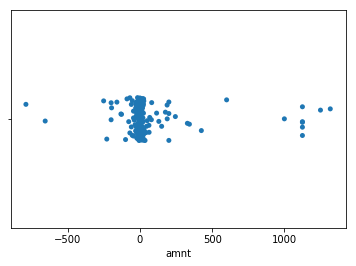

In [13]:
sns.stripplot(x=df['amnt'])

In [14]:
df.loc[df['From'] == 'Lauren Malone']

#all of laurens non-rent transfers to me, for debt or otherwise, are below 1100 dollars, so set a cutoff there and exclude
#all transfers from Lauren above that limit, this avoids including rent payments in the final in-n-out tracker
#the tracker already assumes she's paid that.
i1 = df['From'] == 'Lauren Malone'
i2 = df['amnt'] > 1100

i = i1&i2

df_no_big_lauren = df.loc[~i]

In [18]:
df = df.sort_values(by='Datetime')

In [19]:
df.to_csv(directory + 'venmo_full_hist.csv')

# df_no_big_lauren.to_csv(directory + 'venmo_nobigLauren_hist.csv')

In [20]:
df.resample('M', on='Datetime').sum().to_csv(directory + 'venmo_monthly_hist.csv')
df_no_big_lauren.resample('M', on='Datetime').sum().to_csv(directory + 'venmo_nobigLauren_monthly_hist.csv')